# Own CCM

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance
from scipy.stats import pearsonr
from causal_ccm.causal_ccm import ccm

In [2]:
# shadow manifold functiom

'''
time_series -> Data measured over time (abundance data)
L           -> Length of time series that should be concidered
E           -> Embedding dimension
tau         -> time delay

'''

def shadow_manifold(time_series_Y, L, E, tau):

    shadow_M = {}

    for t in range((E - 1) * tau, L): # iterate through time

        lag = [] # lagged values

        for t2 in range(0, E): # get lags - add 1 to E-1 to include E

            lag.append(time_series_Y[t - t2 * tau]) # access lagged time points and store in list

        shadow_M[t] = lag # add list to dict
    
    return shadow_M

In [3]:
# create matrix with distances between all vectors

def vec_dist_matrx (shadow_M):
    
    # seperate time steps and vectors to create arrays for cdist
    vector = []
    steps = []
    vecs = []

    for a, b in shadow_M.items():
        vector.append((a, b))

    for i in vector:
        steps.append(i[0])
        vecs.append(i[1])

    steps = np.array(steps)
    vecs = np.array(vecs)

    distance_metrics = distance.cdist(vecs, vecs, metric= "euclidean")

    return distance_metrics, steps



In [4]:
# function for dist metrics from time line

def get_dist_metr(shadow_M):

    distance_matrix, steps = vec_dist_matrx(shadow_M)

    return distance_matrix, steps

In [5]:
# get nearest distances and timesteps

def nearest_dist_and_step(timepoint_oi, steps, dist_matr):

    index_timepoint = np.where(steps == timepoint_oi) # get index of timepoint

    dist_timepoint = dist_matr[index_timepoint].squeeze() # distances from vector at time t (this is one row)

    # get top closest vectors
    nearest_indis = np.argsort(dist_timepoint)[1:E + 2] # sort indeces, exlude 0 (distance to itself) -> E+1+1
    
    nearest_timesteps = steps[nearest_indis]
    nearest_distances = dist_timepoint[nearest_indis]

    return nearest_timesteps, nearest_distances



In [6]:
def prediction(timepoint_oi,time_series_X, steps, dist_matrix):
        
    non_zero = 0.000001 # non zero value to avoid pproblems with dividingby zero

    index_timepoint = np.where(steps == timepoint_oi) # get the index of time t

    nearest_timesteps, nearest_distances = nearest_dist_and_step(timepoint_oi, steps, dist_matrix)

    # get weights
    u = np.exp(-nearest_distances / np.max([non_zero, nearest_distances[0]])) # di​ wird exponentiell skaliert um Gewichtungen zu berechnen. Kleinere Distanzen führen zu größeren Gewichtungen
    w = u / np.sum(u) # divide by sum to average in total to 1 

    # get prediction of X
    X_true = time_series_X[timepoint_oi] # get corresponding true X
    X_cor = np.array(time_series_X)[nearest_timesteps] # get corresponding Y to cluster in Mx
    X_hat = (w * X_cor).sum() # get X_hat

    return X_true, X_hat

In [7]:
def run_all(timepoint_oi, time_series_X, shadow_m):

    dist_matrix_Y, steps_Y =  get_dist_metr(shadow_m)

    predicted_vals = prediction(timepoint_oi, time_series_X, steps_Y, dist_matrix_Y)

    return predicted_vals

In [8]:
def find_causality(time_series_X, time_series_Y, L, E, tau):

    My = shadow_manifold(time_series_Y, L, E, tau)

    X_true_list = []
    X_hat_list = []


    for t in list(My.keys()): # for each time step in My
        X_true, X_hat = run_all(t,time_series_X, My) # predict X from My
        X_true_list.append(X_true)
        X_hat_list.append(X_hat)

    x, y = X_true_list, X_hat_list
    r, p = pearsonr(x, y)

    return r, p

X->Y r 0.99 p value 0.0
Y->X r 0.99 p value 0.0


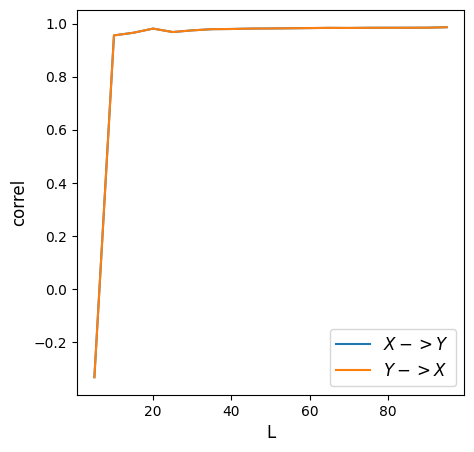

In [9]:
# import data
datapath_for_ccm = 'C:/Users/klbal/Desktop/Internship #2/pivoted_output_2.txt'

ccm_data = pd.read_csv(datapath_for_ccm, delimiter='\t')

# define species to compare

Y_baki = 'Chlamy6'

X_baki = 'Chlamy6'

X_series = ccm_data[X_baki]

Y_series = ccm_data[Y_baki]

# Parameters für den ursprünglichen Datensatz
L = 100  # Length of time series
E = 2    # Embedding dimension
tau = 1  # Time delay

L_range = range(5, L, 5) # L values to test


Xhat_My, Yhat_Mx = [], [] # correlation list

for L in L_range: 

    ccm_XY = find_causality(X_series, Y_series, L, E, tau) # define new ccm object # Testing for X -> Y
    ccm_YX = find_causality(Y_series, X_series, L, E, tau) # define new ccm object # Testing for Y -> X    
    Xhat_My.append(ccm_XY[0]) 
    Yhat_Mx.append(ccm_YX[0]) 
    
    
print('X->Y r', np.round(Xhat_My[-1], 2), 'p value', np.round(ccm_XY[1], 4))
print('Y->X r', np.round(Yhat_Mx[-1], 2), 'p value', np.round(ccm_YX[1], 4))    
    
# plot convergence. Convergence is necessary to conclude causality
plt.figure(figsize=(5,5))
plt.plot(L_range, Xhat_My, label='$X->Y$')
plt.plot(L_range, Yhat_Mx, label='$Y->X$')
plt.xlabel('L', size=12)
plt.ylabel('correl', size=12)
plt.legend(prop={'size': 12})  

# 4 Species Model

In [10]:
import pandas as pd
import numpy as np

# Define the number of time points
T = 500

# Initialize arrays to store the time series
y1 = np.zeros(T)
y2 = np.zeros(T)
y3 = np.zeros(T)
y4 = np.zeros(T)

# Initial conditions
y1[0] = 0.4
y2[0] = 0.4
y3[0] = 0.4
y4[0] = 0.4

# Iterate over time points to compute the values using the given equations
for t in range(T - 1):
    y1[t + 1] = y1[t] * (3.9 - 3.9 * y1[t])
    y2[t + 1] = y2[t] * (3.6 - 0.4 * y1[t] - 3.6 * y2[t])
    y3[t + 1] = y3[t] * (3.6 - 0.4 * y2[t] - 3.6 * y3[t])
    y4[t + 1] = y4[t] * (3.8 - 0.35 * y3[t] - 3.8 * y4[t])

# Create time points (1 to T)
time_points = np.arange(1, T + 1)

# Create DataFrame for each time series
df_y1 = pd.DataFrame({'Zeitpunkte': time_points, 'Werte': y1})
df_y2 = pd.DataFrame({'Zeitpunkte': time_points, 'Werte': y2})
df_y3 = pd.DataFrame({'Zeitpunkte': time_points, 'Werte': y3})
df_y4 = pd.DataFrame({'Zeitpunkte': time_points, 'Werte': y4})

y1_4S = df_y1["Werte"]
y2_4S = df_y2["Werte"]
y3_4S = df_y3["Werte"]
y4_4S = df_y4["Werte"]




In [11]:
'''

# checking convergence

# Parameters für den ursprünglichen Datensatz
L = len(y1_4S)  # Length of time series
E = 2    # Embedding dimension
tau = 1  # Time delay

L_range = range(5, L, 5) # L values to test


Xhat_My, Yhat_Mx = [], [] # correlation list
for L in L_range: 
    ccm_XY = find_causality(y1_4S, y2_4S, L, E, tau) # define new ccm object # Testing for X -> Y
    ccm_YX = find_causality(y2_4S, y1_4S, L, E, tau) # define new ccm object # Testing for Y -> X    
    Xhat_My.append(ccm_XY[0]) 
    Yhat_Mx.append(ccm_YX[0]) 
    
print('X->Y r', np.round(Xhat_My[-1], 2), 'p value', np.round(ccm_XY[1], 4))
print('Y->X r', np.round(Yhat_Mx[-1], 2), 'p value', np.round(ccm_YX[1], 4))    
    
# plot convergence. Convergence is necessary to conclude causality
plt.figure(figsize=(5,5))
plt.plot(L_range, Xhat_My, label='$\hat{X}(t)|M_y$')
plt.plot(L_range, Yhat_Mx, label='$\hat{Y}(t)|M_x$')
plt.xlabel('L', size=12)
plt.ylabel('correl', size=12)
plt.legend(prop={'size': 12})  

'''

"\n\n# checking convergence\n\n# Parameters für den ursprünglichen Datensatz\nL = len(y1_4S)  # Length of time series\nE = 2    # Embedding dimension\ntau = 1  # Time delay\n\nL_range = range(5, L, 5) # L values to test\n\n\nXhat_My, Yhat_Mx = [], [] # correlation list\nfor L in L_range: \n    ccm_XY = find_causality(y1_4S, y2_4S, L, E, tau) # define new ccm object # Testing for X -> Y\n    ccm_YX = find_causality(y2_4S, y1_4S, L, E, tau) # define new ccm object # Testing for Y -> X    \n    Xhat_My.append(ccm_XY[0]) \n    Yhat_Mx.append(ccm_YX[0]) \n    \nprint('X->Y r', np.round(Xhat_My[-1], 2), 'p value', np.round(ccm_XY[1], 4))\nprint('Y->X r', np.round(Yhat_Mx[-1], 2), 'p value', np.round(ccm_YX[1], 4))    \n    \n# plot convergence. Convergence is necessary to conclude causality\nplt.figure(figsize=(5,5))\nplt.plot(L_range, Xhat_My, label='$\\hat{X}(t)|M_y$')\nplt.plot(L_range, Yhat_Mx, label='$\\hat{Y}(t)|M_x$')\nplt.xlabel('L', size=12)\nplt.ylabel('correl', size=12)\nplt.legen

In [12]:
'''
# checking convergence

# Parameters für den ursprünglichen Datensatz
L = len(y1_4S)  # Length of time series
E = 2    # Embedding dimension
tau = 1  # Time delay

L_range = range(5, L, 5) # L values to test


Xhat_My, Yhat_Mx = [], [] # correlation list
for L in L_range: 
    ccm_XY = find_causality(y2_4S, y3_4S, L, E, tau) # define new ccm object # Testing for X -> Y
    ccm_YX = find_causality(y3_4S, y2_4S, L, E, tau) # define new ccm object # Testing for Y -> X    
    Xhat_My.append(ccm_XY[0]) 
    Yhat_Mx.append(ccm_YX[0]) 
    
print('X->Y r', np.round(Xhat_My[-1], 2), 'p value', np.round(ccm_XY[1], 4))
print('Y->X r', np.round(Yhat_Mx[-1], 2), 'p value', np.round(ccm_YX[1], 4))    
    
# plot convergence. Convergence is necessary to conclude causality
plt.figure(figsize=(5,5))
plt.plot(L_range, Xhat_My, label='$\hat{X}(t)|M_y$')
plt.plot(L_range, Yhat_Mx, label='$\hat{Y}(t)|M_x$')
plt.xlabel('L', size=12)
plt.ylabel('correl', size=12)
plt.legend(prop={'size': 12})  

'''

"\n# checking convergence\n\n# Parameters für den ursprünglichen Datensatz\nL = len(y1_4S)  # Length of time series\nE = 2    # Embedding dimension\ntau = 1  # Time delay\n\nL_range = range(5, L, 5) # L values to test\n\n\nXhat_My, Yhat_Mx = [], [] # correlation list\nfor L in L_range: \n    ccm_XY = find_causality(y2_4S, y3_4S, L, E, tau) # define new ccm object # Testing for X -> Y\n    ccm_YX = find_causality(y3_4S, y2_4S, L, E, tau) # define new ccm object # Testing for Y -> X    \n    Xhat_My.append(ccm_XY[0]) \n    Yhat_Mx.append(ccm_YX[0]) \n    \nprint('X->Y r', np.round(Xhat_My[-1], 2), 'p value', np.round(ccm_XY[1], 4))\nprint('Y->X r', np.round(Yhat_Mx[-1], 2), 'p value', np.round(ccm_YX[1], 4))    \n    \n# plot convergence. Convergence is necessary to conclude causality\nplt.figure(figsize=(5,5))\nplt.plot(L_range, Xhat_My, label='$\\hat{X}(t)|M_y$')\nplt.plot(L_range, Yhat_Mx, label='$\\hat{Y}(t)|M_x$')\nplt.xlabel('L', size=12)\nplt.ylabel('correl', size=12)\nplt.legend(

# CCM for all combinations

In [13]:
print(ccm_data)

     Chlamy107  Chlamy123  Chlamy125  Chlamy165  Chlamy19  Chlamy23  Chlamy24  \
0     0.479167    0.00000   4.541667   0.125000  0.166667  0.140625  0.166667   
1     0.312500    0.12500  19.770833   0.812500  0.041667  0.000000  0.875000   
2     0.208333    0.06250  19.500000   0.875000  0.041667  0.000000  0.833333   
3     0.250000    0.12500  19.270833   0.583333  0.000000  0.000000  0.708333   
4     0.333333    0.21875  17.645833   0.312500  0.041667  0.000000  0.416667   
..         ...        ...        ...        ...       ...       ...       ...   
105   0.000000    0.06250   2.562500   0.354167  0.000000  0.000000  0.000000   
106   0.000000    0.03125   2.375000   0.437500  0.000000  0.000000  0.000000   
107   0.000000    0.03125   2.708333   0.479167  0.000000  0.015625  0.000000   
108   0.000000    0.06250   1.979167   0.187500  0.000000  0.000000  0.000000   
109   0.000000    0.03125   2.541667   0.333333  0.000000  0.000000  0.041667   

     Chlamy26  Chlamy28  Ch

In [14]:
print(len(ccm_data.index))

110


In [15]:
L = 110 # Length of time series
E = 2    # Embedding dimension
tau = 1  # Time delay


empty_df = pd.DataFrame(index=ccm_data.columns, columns=ccm_data.columns)



for bak1 in ccm_data.columns:
    for bak2 in ccm_data.columns:

        X_series_it = ccm_data[bak1]
        Y_series_it = ccm_data[bak2]



        ccm_pair = find_causality(X_series_it, Y_series_it, L, E, tau)
        
        if ccm_pair[0] >= 0:
            empty_df.loc[bak1, bak2] = round(ccm_pair[0],4)

        else:
            empty_df.loc[bak1, bak2] = 0




print(empty_df)



C:\Users\klbal\AppData\Local\Temp\ipykernel_21648\1577300069.py:15: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(x, y)


          Chlamy107 Chlamy123 Chlamy125 Chlamy165 Chlamy19 Chlamy23 Chlamy24  \
Chlamy107    0.9771    0.4801    0.6898    0.1672   0.0356    0.471   0.6043   
Chlamy123    0.1221    0.9922         0    0.2274        0   0.0454    0.167   
Chlamy125    0.8144    0.2815    0.9893    0.4252   0.1786        0   0.9465   
Chlamy165    0.5379    0.4683    0.7636    0.9769   0.3804   0.2676   0.4644   
Chlamy19          0    0.3343    0.2034    0.1991   0.8916   0.3208        0   
Chlamy23     0.2821    0.3924    0.0433    0.1198   0.0926   0.9655   0.4348   
Chlamy24     0.8659    0.1605    0.8762    0.4408   0.0833   0.0445   0.9731   
Chlamy26     0.5656    0.4803    0.4884    0.4052        0   0.4993   0.5363   
Chlamy28     0.2585    0.6228    0.3678     0.388   0.3191   0.1959   0.2406   
Chlamy43     0.3499         0    0.2016    0.2314   0.0487        0        0   
Chlamy44     0.8218         0    0.3001         0   0.0291        0   0.2242   
Chlamy45     0.5842     0.485    0.3736 

In [16]:
empty_df = empty_df.fillna(0) 

C:\Users\klbal\AppData\Local\Temp\ipykernel_21648\2224679143.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  empty_df = empty_df.fillna(0)


<Figure size 1000x800 with 0 Axes>

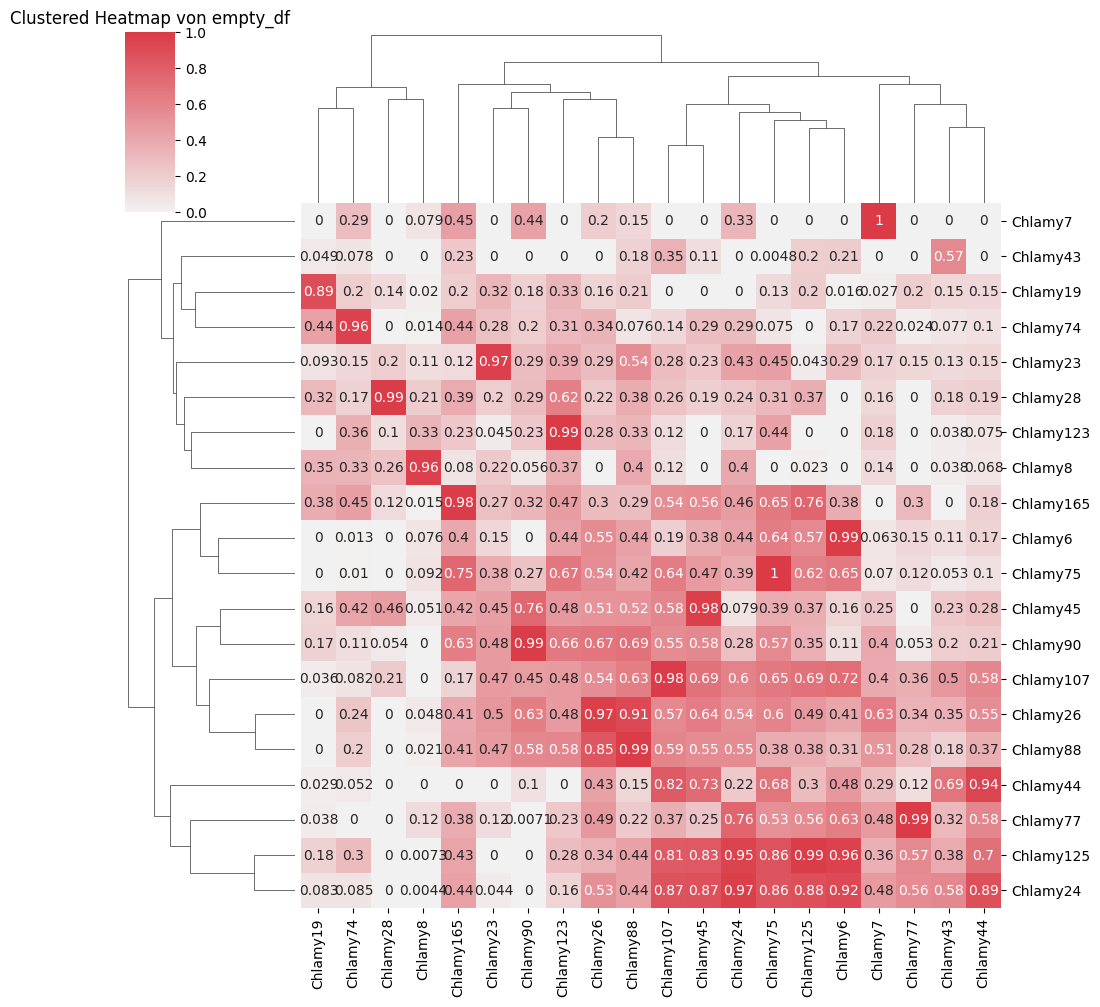

In [17]:
cmap = sns.diverging_palette(250, 10, as_cmap=True)

plt.figure(figsize=(10, 8))
sns.clustermap(empty_df, annot=True, cmap=cmap, cbar=True, center=0)

plt.title('Clustered Heatmap von empty_df')

plt.show()

In [18]:
best_bacis = ["Chlamy75", "Chlamy6", "Chlamy45", "Chlamy28", "Chlamy125", "Chlamy123"]

filtered_ccm = empty_df.loc[best_bacis]

filtered_ccm = filtered_ccm[best_bacis]

print(filtered_ccm)

           Chlamy75  Chlamy6  Chlamy45  Chlamy28  Chlamy125  Chlamy123
Chlamy75     0.9960   0.6548    0.4736    0.0000     0.6212     0.6704
Chlamy6      0.6387   0.9880    0.3810    0.0000     0.5692     0.4380
Chlamy45     0.3864   0.1578    0.9756    0.4639     0.3736     0.4850
Chlamy28     0.3064   0.0000    0.1892    0.9915     0.3678     0.6228
Chlamy125    0.8618   0.9569    0.8323    0.0000     0.9893     0.2815
Chlamy123    0.4359   0.0000    0.0000    0.1024     0.0000     0.9922


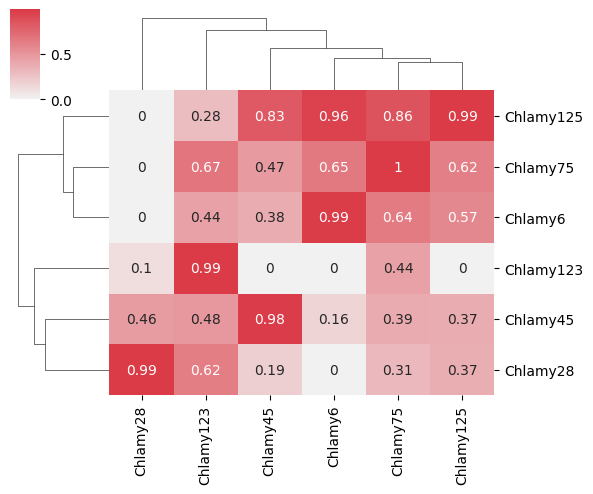

In [19]:
cmap = sns.diverging_palette(250, 10, as_cmap=True)

sns.clustermap(
    filtered_ccm,
    row_cluster=True,  
    col_cluster=True,  
    annot=True,
    cmap=cmap,
    cbar=True,
    center=0,
    figsize=(6, 5)

)

#plt.suptitle('Heatmap of Co-Occurrence Matrix - CCM', y=1.02)

plt.show()

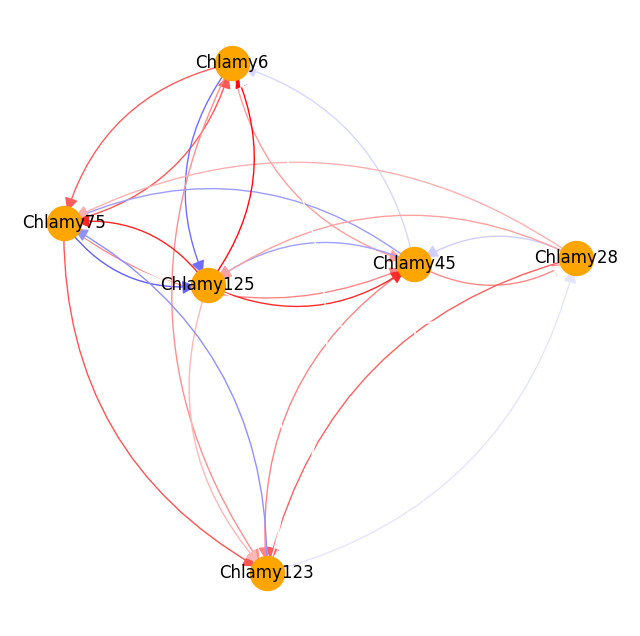

In [20]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

threshold = 0

# Construct the directed network
G = nx.DiGraph()  # Create an empty directed graph

# Add nodes (taxa or variables) to the graph
G.add_nodes_from(filtered_ccm.columns)

# Add directed edges (causal relationships) to the graph in both directions
for i, row in filtered_ccm.iterrows():
    for j, value in row.items():
        if i != j:  # Check if the causation score is above the threshold and not self-loop
            G.add_edge(i, j, weight=value)
            G.add_edge(j, i, weight=filtered_ccm.loc[j, i])  # Add the reverse direction edge

edges = G.edges()

edge_colors = []
for u, v in edges:
    weight_uv = G[u][v]['weight']
    weight_vu = G[v][u]['weight']

    if abs(weight_uv - weight_vu) <= 0.05 * max(abs(weight_uv), abs(weight_vu)):  # Within 5% Spielraum
        color = (1, 1-weight_uv, 1-weight_uv)  # Red gradient
    elif weight_uv > weight_vu:
        color = (1, 1-weight_uv, 1-weight_uv)  # Red gradient
    else:
        color = (1-weight_uv, 1-weight_uv, 1)  # Blue gradient

    edge_colors.append(color)

# Use spring layout
pos = nx.spring_layout(G)

# Plot the network
plt.figure(figsize=(8, 8))

# Draw the nodes
nx.draw_networkx_nodes(G, pos, node_color='orange', node_size=600)

# Draw the edges with curved arrows
nx.draw_networkx_edges(
    G, pos, 
    edgelist=G.edges(), 
    edge_color=edge_colors, 
    width=1, 
    arrowstyle='-|>', 
    arrowsize=20, 
    connectionstyle="arc3,rad=0.3"  # Adjust the curvature here
)

# Draw the labels
nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')

# Remove axis and spines
plt.axis('off')  # Hide the axis
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.show()



X->Y r 0.83 p value 0.0
Y->X r 0.37 p value 0.0001


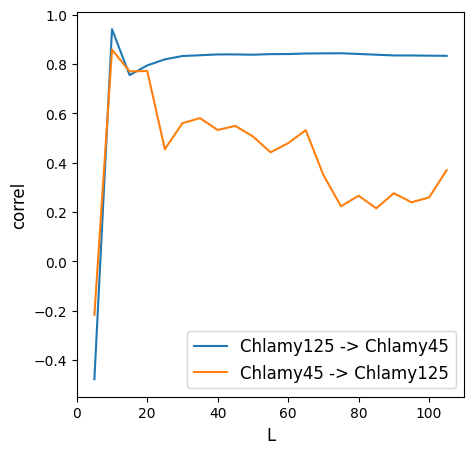

In [21]:
# import data
datapath_for_ccm = 'C:/Users/klbal/Desktop/Internship #2/pivoted_output_2.txt'

ccm_data = pd.read_csv(datapath_for_ccm, delimiter='\t')

# define species to compare

Y_baki = 'Chlamy45'

X_baki = 'Chlamy125'

X_series = ccm_data[X_baki]

Y_series = ccm_data[Y_baki]

# Parameters für den ursprünglichen Datensatz
L = 110  # Length of time series
E = 2    # Embedding dimension
tau = 1  # Time delay

L_range = range(5, L, 5) # L values to test


Xhat_My, Yhat_Mx = [], [] # correlation list

for L in L_range: 

    ccm_XY = find_causality(X_series, Y_series, L, E, tau) # define new ccm object # Testing for X -> Y
    ccm_YX = find_causality(Y_series, X_series, L, E, tau) # define new ccm object # Testing for Y -> X    
    Xhat_My.append(ccm_XY[0]) 
    Yhat_Mx.append(ccm_YX[0]) 
    
    
print('X->Y r', np.round(Xhat_My[-1], 2), 'p value', np.round(ccm_XY[1], 4))
print('Y->X r', np.round(Yhat_Mx[-1], 2), 'p value', np.round(ccm_YX[1], 4))    
    
# plot convergence. Convergence is necessary to conclude causality
plt.figure(figsize=(5,5))
plt.plot(L_range, Xhat_My, label= str(X_baki + " -> " + Y_baki))
plt.plot(L_range, Yhat_Mx, label=str(Y_baki + " -> " + X_baki))
plt.xlabel('L', size=12)
plt.ylabel('correl', size=12)
plt.legend(prop={'size': 12})  

effect of bottom to right 6->125 == 0.96

In [22]:
# Validation data

datapath_for_vali = 'C:/Users/klbal/Desktop/Internship #2/validation_data.csv'

vali_data = pd.read_csv(datapath_for_vali)

vali_data = vali_data.drop(columns='Day')

print(vali_data)

           y1        y2        y3        y4        y5        y6        y7  \
0    0.500000  0.300000  0.600000  0.700000  0.600000  0.400000  0.500000   
1    0.335840  0.239143  0.651967  0.660025  0.385840  0.455357  0.699999   
2    0.915866  0.091639  0.788474  0.528330  0.520131  0.332825  0.751587   
3    1.370003  0.428096  0.392352  0.738801  0.717486  0.242167  0.743545   
4    0.803054  1.014852  0.879930  0.373399  0.406236  0.170681  0.505191   
..        ...       ...       ...       ...       ...       ...       ...   
105  0.433375  0.526932 -0.038173  0.181067  0.318083 -0.014902  0.581087   
106 -0.743110  0.696815  0.005939 -0.160384 -0.315488 -0.032381  0.738343   
107 -1.026539  0.281342 -0.224326 -0.126758 -0.449157  0.141230  0.867492   
108 -0.415158  0.334860  0.012129 -0.078532 -0.218858  0.257250  0.812862   
109  0.802576  0.474902 -0.005657 -0.027502  0.437317  0.171843  0.650948   

           y8        y9       y10       y11       y12  
0    0.600000  0.70

In [23]:
L = len(vali_data.index)  # Length of time series
E = 2    # Embedding dimension
tau = 1  # Time delay

empty_df = pd.DataFrame(index=vali_data.columns, columns=vali_data.columns)

for bak1 in vali_data.columns:

    for bak2 in vali_data.columns:

        X_series_it = vali_data[bak1]
        Y_series_it = vali_data[bak2]


            
        ccm_pair = find_causality(X_series_it, Y_series_it, L, E, tau)

        if ccm_pair[0] >= 0:
            empty_df.loc[bak1, bak2] = round(ccm_pair[0],4)

        else:
            empty_df.loc[bak1, bak2] = 0
                

            

ccm_vali = empty_df.astype(float)

print(ccm_vali)

         y1      y2      y3      y4      y5      y6      y7      y8      y9  \
y1   0.9980  0.0000  0.1420  0.0000  0.9842  0.2294  0.0000  0.1098  0.2263   
y2   0.7556  0.9719  0.0000  0.0930  0.7269  0.0707  0.0000  0.0000  0.0000   
y3   0.1934  0.0000  0.9907  0.7523  0.1350  0.1427  0.1692  0.2188  0.3783   
y4   0.0000  0.0000  0.8307  0.9900  0.0000  0.0586  0.0000  0.0000  0.4907   
y5   0.9790  0.0000  0.1455  0.0000  0.9965  0.2121  0.0000  0.0966  0.2067   
y6   0.0266  0.4020  0.1702  0.0000  0.1180  0.9918  0.2856  0.0000  0.5631   
y7   0.0000  0.0000  0.0000  0.0000  0.0000  0.5139  0.9899  0.4501  0.0000   
y8   0.0437  0.0422  0.0000  0.0000  0.0000  0.0000  0.5064  0.9898  0.0000   
y9   0.0000  0.1426  0.2747  0.3160  0.0000  0.2973  0.0776  0.0000  0.9953   
y10  0.0000  0.1789  0.0000  0.0000  0.0000  0.5575  0.0085  0.0000  0.8755   
y11  0.0000  0.0273  0.0572  0.2197  0.0000  0.1641  0.0000  0.0000  0.4132   
y12  0.0000  0.0867  0.0911  0.0969  0.0000  0.3052 

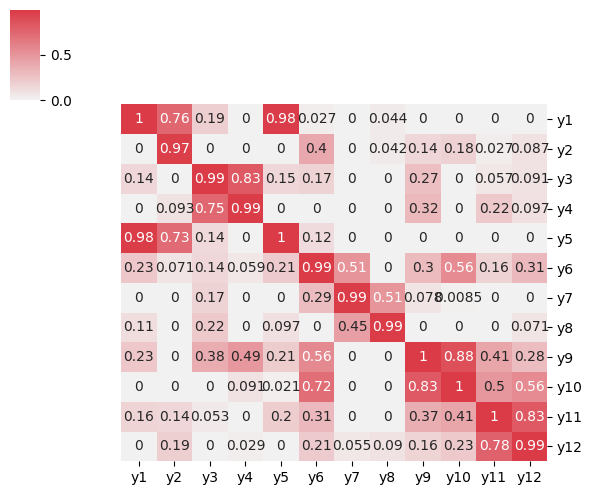

In [24]:

ccm_vali_transposed = ccm_vali.T

cmap = sns.diverging_palette(250, 10, as_cmap=True)



sns.clustermap(
    ccm_vali_transposed,
    row_cluster=False,  
    col_cluster=False,  
    annot=True,
    cmap=cmap,
    cbar=True,
    center=0,
    figsize=(6, 5)

)

#plt.suptitle('Cluster-Heatmap of Co-Occurrence Matrix (Validation) - CCM', y=1.02)

plt.show()

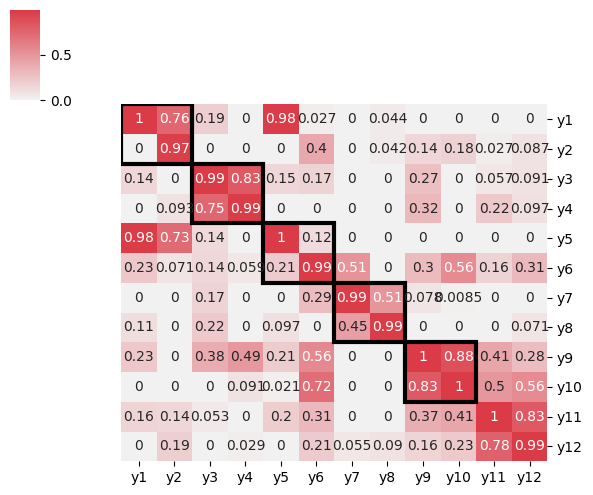

In [25]:
from matplotlib.patches import Rectangle


# Define a diverging colormap
cmap = sns.diverging_palette(250, 10, as_cmap=True)

# Create the clustermap
g = sns.clustermap(
    ccm_vali_transposed,
    row_cluster=False,  
    col_cluster=False,  
    annot=True,
    cmap=cmap,
    cbar=True,
    center=0,
    figsize=(6, 5)
)

# Define packs of 4 tiles (2x2 blocks) and neighboring pairs
packs = [
    (0, 0), (2, 2), (4, 4), (6, 6), (8, 8)
]  # Example indices (modify these according to your actual data)

# Access the heatmap axes
ax = g.ax_heatmap

# Highlight the borders of packs of 4 tiles
for (i, j) in packs:
    rect = Rectangle((j, i), 2, 2, edgecolor='black', facecolor='none', linewidth=3)
    ax.add_patch(rect)

# Optionally, add a title
#plt.suptitle('Cluster-Heatmap of Co-Occurrence Matrix (Validation) - CCM', y=1.02)

plt.show()


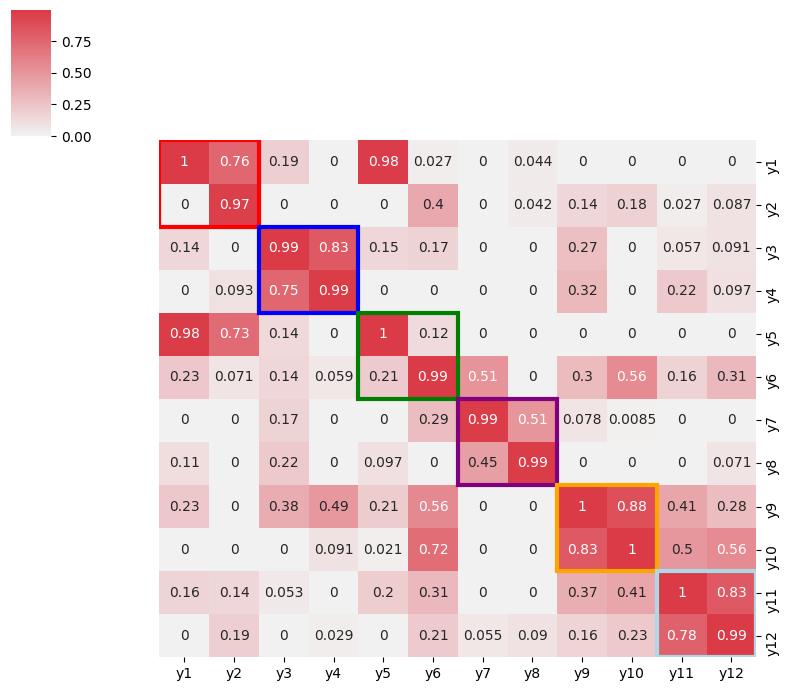

In [28]:
# Define a diverging colormap
cmap = sns.diverging_palette(250, 10, as_cmap=True)

# Create the clustermap
g = sns.clustermap(
    ccm_vali_transposed,
    row_cluster=False,  
    col_cluster=False,  
    annot=True,
    cmap=cmap,
    cbar=True,
    center=0,
    figsize=(8, 7)
)

# Define packs of 4 tiles (2x2 blocks) and neighboring pairs
packs = [
    (0, 0), (2, 2), (4, 4), (6, 6), (8, 8), (10, 10)
]  # Example indices (modify these according to your actual data)

# Define a list of colors for the rectangles
colors = ['red', 'blue', 'green', 'purple', 'orange', "lightblue"]

# Access the heatmap axes
ax = g.ax_heatmap

# Highlight the borders of packs of 4 tiles with different colors
for (index, (i, j)) in enumerate(packs):
    rect = Rectangle((j, i), 2, 2, edgecolor=colors[index % len(colors)], facecolor="none", linewidth=3)
    ax.add_patch(rect)

# Optionally, add a title
#plt.suptitle('Heatmap of Causal Influence Matrix (Validation) - CCM', y=1.02)

plt.show()

X->Y r 0.83 p value 0.0
Y->X r 0.78 p value 0.0


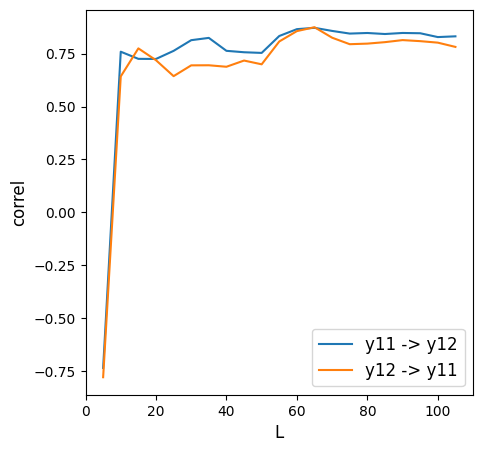

In [27]:


Y_baki = 'y11'

X_baki = 'y12'

X_series = vali_data[X_baki]

Y_series = vali_data[Y_baki]

# Parameters für den ursprünglichen Datensatz
L = 110  # Length of time series
E = 2    # Embedding dimension
tau = 1  # Time delay

L_range = range(5, L, 5) # L values to test


Xhat_My, Yhat_Mx = [], [] # correlation list

for L in L_range: 

    ccm_XY = find_causality(X_series, Y_series, L, E, tau) # define new ccm object # Testing for X -> Y
    ccm_YX = find_causality(Y_series, X_series, L, E, tau) # define new ccm object # Testing for Y -> X    
    Xhat_My.append(ccm_XY[0]) 
    Yhat_Mx.append(ccm_YX[0]) 
    
    
print('X->Y r', np.round(Xhat_My[-1], 2), 'p value', np.round(ccm_XY[1], 4))
print('Y->X r', np.round(Yhat_Mx[-1], 2), 'p value', np.round(ccm_YX[1], 4))    
    
# plot convergence. Convergence is necessary to conclude causality
plt.figure(figsize=(5,5))
plt.plot(L_range, Xhat_My, label= str(Y_baki + " -> " + X_baki))
plt.plot(L_range, Yhat_Mx, label=str(X_baki + " -> " + Y_baki))
plt.xlabel('L', size=12)
plt.ylabel('correl', size=12)
plt.legend(prop={'size': 12})  